# RESUMO

# IMPORTANDO BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import PowerTransformer
from scipy.stats import skew, boxcox, yeojohnson
from scipy.special import inv_boxcox
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

tqdm.pandas()


c:\Users\VitorAquino\anaconda3\envs\renner\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**LINK DEMONSTRANDO AS COMPARAÇÕES** <br>
https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9


# CARREGANDO DADOS

In [2]:
df_train = pd.read_csv('dados/train.csv')
df_test = pd.read_csv('dados/test.csv')
df_submission = pd.read_csv('dados/sample_submission.csv')

# Distribuição da variável target

In [3]:
target_testes = df_train[['yield']]

## SEM TRANSFORMAÇÃO

<Figure size 2000x800 with 0 Axes>

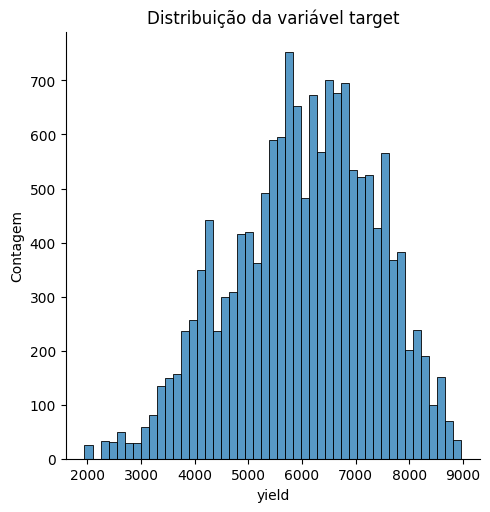

In [4]:
plt.figure(figsize=(20,8))
sns.displot(target_testes, x="yield")
plt.title('Distribuição da variável target')
plt.ylabel('Contagem')
plt.show()

In [5]:
target_testes['yield'].kurtosis()

-0.436563864726061

In [6]:
target_testes['yield'].skew()

-0.29119496049488897

## LOGARITMO
VALORES DIFERENTES DE 0

In [7]:
target_testes['log_yield'] = np.log1p(target_testes["yield"])

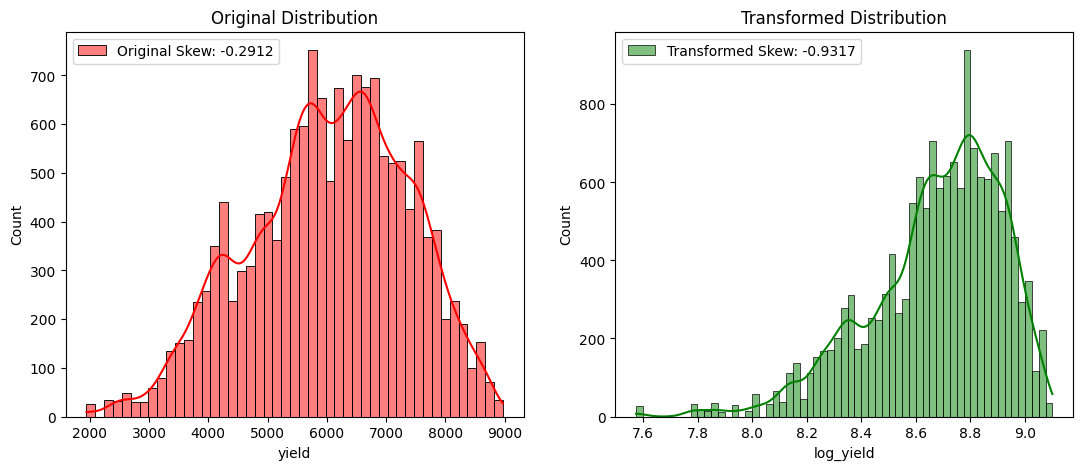

In [8]:
# Configurar o tamanho da figura
plt.rcParams["figure.figsize"] = 13, 5

# Plotar as distribuições antes e depois da transformação
fig, ax = plt.subplots(1, 2)
sns.histplot(target_testes["yield"], kde=True, color="r", label="Original Skew: {0}".format(np.round(target_testes["yield"].skew(), 4)), ax=ax[0])
sns.histplot(target_testes['log_yield'], kde=True, color="g", label="Transformed Skew: {0}".format(np.round(target_testes['log_yield'].skew(), 4)), ax=ax[1])

# Adicionar legendas e títulos aos gráficos
ax[0].legend()
ax[0].set_title("Original Distribution")
ax[1].legend()
ax[1].set_title("Transformed Distribution")

plt.show()

A transformação por logaritmo piorou a skewness da curva

## RAIZ QUADRADA

In [9]:
target_testes['sqrt_yield'] = np.sqrt(target_testes["yield"])

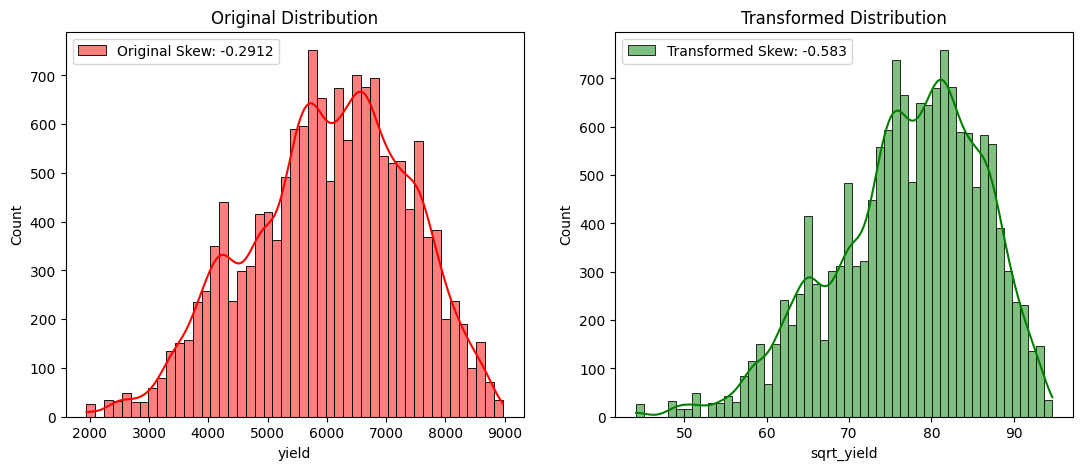

In [10]:
# Configurar o tamanho da figura
plt.rcParams["figure.figsize"] = 13, 5

# Plotar as distribuições antes e depois da transformação
fig, ax = plt.subplots(1, 2)
sns.histplot(target_testes["yield"], kde=True, color="r", label="Original Skew: {0}".format(np.round(target_testes["yield"].skew(), 4)), ax=ax[0])
sns.histplot(target_testes['sqrt_yield'], kde=True, color="g", label="Transformed Skew: {0}".format(np.round(target_testes['sqrt_yield'].skew(), 4)), ax=ax[1])

# Adicionar legendas e títulos aos gráficos
ax[0].legend()
ax[0].set_title("Original Distribution")
ax[1].legend()
ax[1].set_title("Transformed Distribution")

plt.show()

## TRANSFORMAÇÃO RECÍPROCA
VALORES DIFERENTES DE ZERO

In [11]:
target_testes['reciprocal_yield'] = 1/target_testes["yield"]

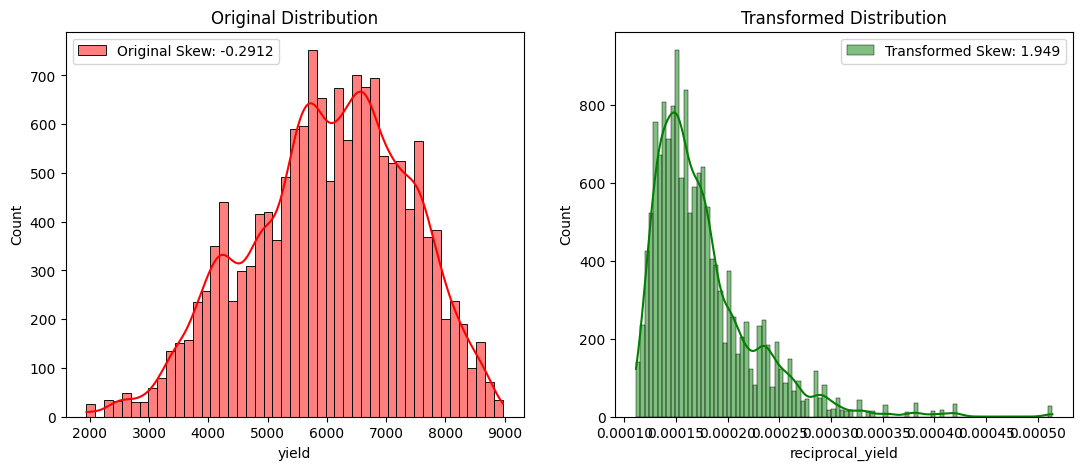

In [12]:
# Configurar o tamanho da figura
plt.rcParams["figure.figsize"] = 13, 5

# Plotar as distribuições antes e depois da transformação
fig, ax = plt.subplots(1, 2)
sns.histplot(target_testes["yield"], kde=True, color="r", label="Original Skew: {0}".format(np.round(target_testes["yield"].skew(), 4)), ax=ax[0])
sns.histplot(target_testes['reciprocal_yield'], kde=True, color="g", label="Transformed Skew: {0}".format(np.round(target_testes['reciprocal_yield'].skew(), 4)), ax=ax[1])

# Adicionar legendas e títulos aos gráficos
ax[0].legend()
ax[0].set_title("Original Distribution")
ax[1].legend()
ax[1].set_title("Transformed Distribution")

plt.show()

## BOX-COX 
VALORES ESTRITAMENTE POSITIVOS

In [13]:
target_testes['boxcox_yield'], _ = boxcox(target_testes["yield"])

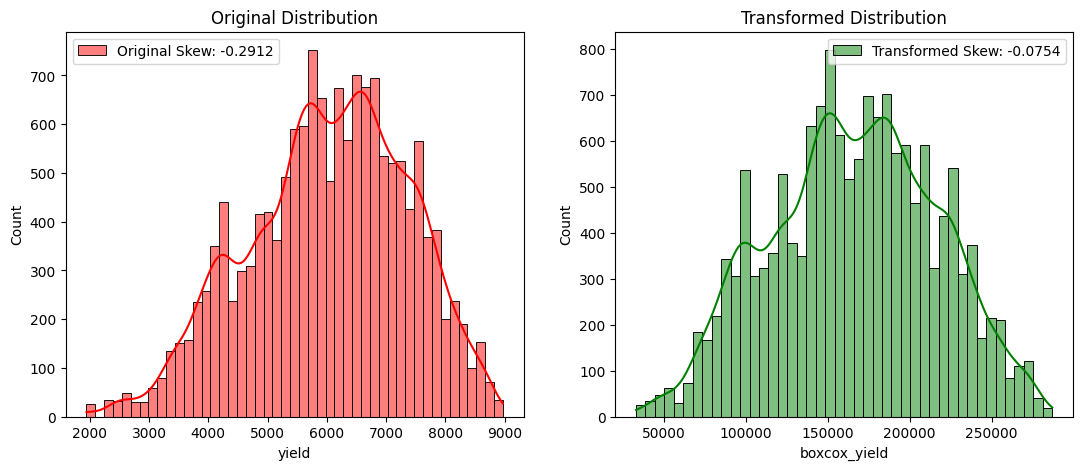

In [14]:
# Configurar o tamanho da figura
plt.rcParams["figure.figsize"] = 13, 5

# Plotar as distribuições antes e depois da transformação
fig, ax = plt.subplots(1, 2)
sns.histplot(target_testes["yield"], kde=True, color="r", label="Original Skew: {0}".format(np.round(target_testes["yield"].skew(), 4)), ax=ax[0])
sns.histplot(target_testes['boxcox_yield'], kde=True, color="g", label="Transformed Skew: {0}".format(np.round(target_testes['boxcox_yield'].skew(), 4)), ax=ax[1])

# Adicionar legendas e títulos aos gráficos
ax[0].legend()
ax[0].set_title("Original Distribution")
ax[1].legend()
ax[1].set_title("Transformed Distribution")

plt.show()

## YEO-JOHNSON

In [15]:
target_testes['yeojohnson_yield'], _ = yeojohnson(target_testes["yield"])

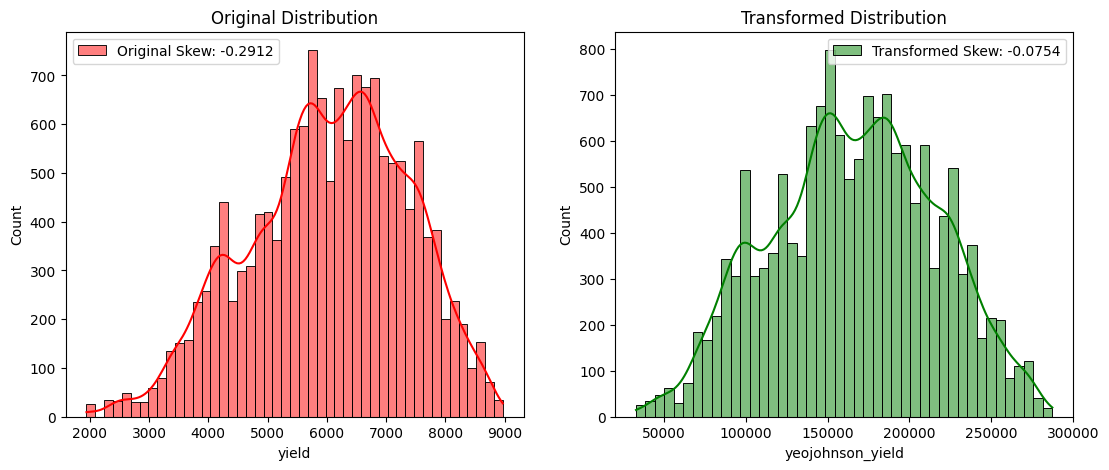

In [16]:
# Configurar o tamanho da figura
plt.rcParams["figure.figsize"] = 13, 5

# Plotar as distribuições antes e depois da transformação
fig, ax = plt.subplots(1, 2)
sns.histplot(target_testes["yield"], kde=True, color="r", label="Original Skew: {0}".format(np.round(target_testes["yield"].skew(), 4)), ax=ax[0])
sns.histplot(target_testes['yeojohnson_yield'], kde=True, color="g", label="Transformed Skew: {0}".format(np.round(target_testes['yeojohnson_yield'].skew(), 4)), ax=ax[1])

# Adicionar legendas e títulos aos gráficos
ax[0].legend()
ax[0].set_title("Original Distribution")
ax[1].legend()
ax[1].set_title("Transformed Distribution")

plt.show()

# MODELOS

In [17]:

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [18]:
lista_transformacao_utilizado = []
lista_num_features = []
lista_MAE = []

## SEM TRANSFORMAÇÃO

In [19]:
def teste_de_modelo_SEM_TRANSFORMACAO(X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        OLS = LinearRegression()
        OLS = OLS.fit(X_train, y_train)
        y_pred = OLS.predict(X_test).squeeze().tolist()

        MAE = mean_absolute_error(y_true=y_test, y_pred=y_pred)
        MAE_scores.append(MAE)


    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = OLS.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 376.17378276148435
Desvio padrão dos scores de MAE: 14.56552749259025


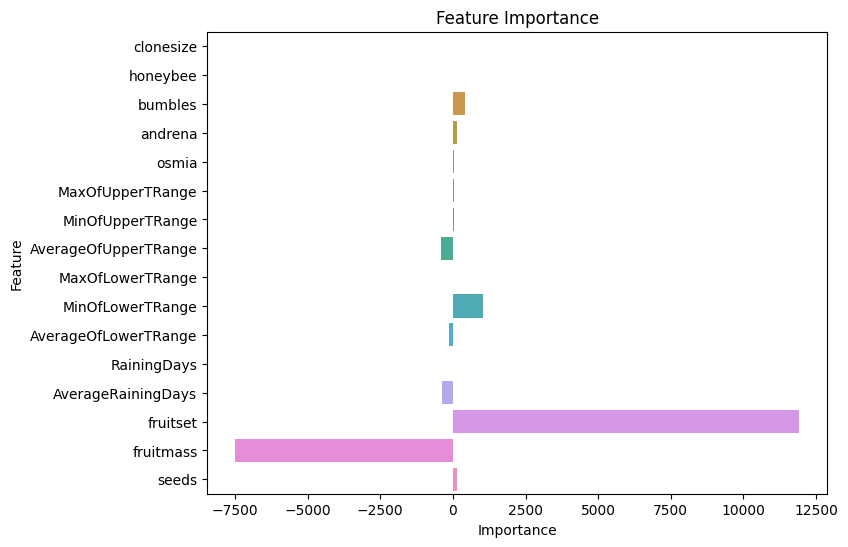

In [20]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]



MAE_modelo, num_features  = teste_de_modelo_SEM_TRANSFORMACAO(X, y)

lista_transformacao_utilizado.append('SEM TRANSFORMAÇÃO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 372.57083033800353
Desvio padrão dos scores de MAE: 5.584087307749434


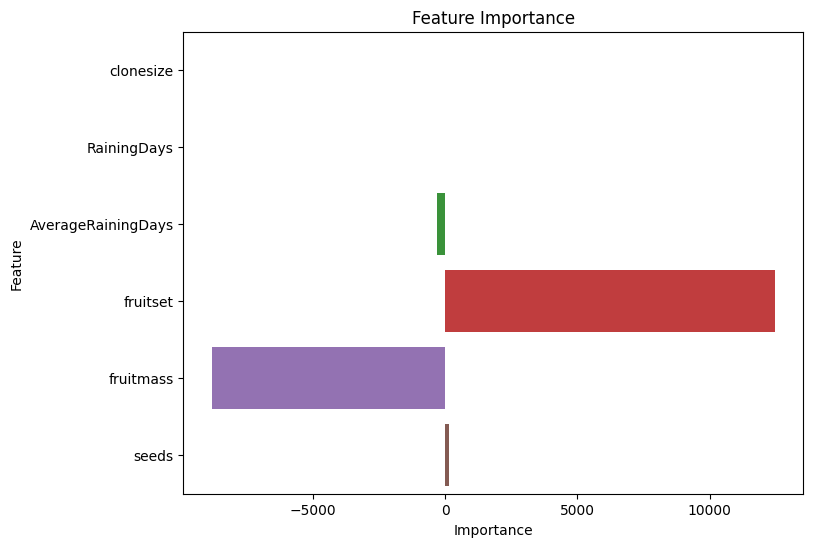

In [21]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_SEM_TRANSFORMACAO(X, y)

lista_transformacao_utilizado.append('SEM TRANSFORMAÇÃO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## LOGARITMO

In [22]:
def teste_de_modelo_LOGARITMO(X, y, n_splits=5):

    # Transformação logaritmica
    y['yield'] = np.log1p(y["yield"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        OLS = LinearRegression()
        OLS = OLS.fit(X_train, y_train)
        y_pred = OLS.predict(X_test).squeeze().tolist()

        y_pred_corrigido = np.expm1(y_pred)
        y_test_corrigido = np.expm1(y_test)

        MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)
        MAE_scores.append(MAE)


    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = OLS.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 430.5615779159495
Desvio padrão dos scores de MAE: 59.84640478778191


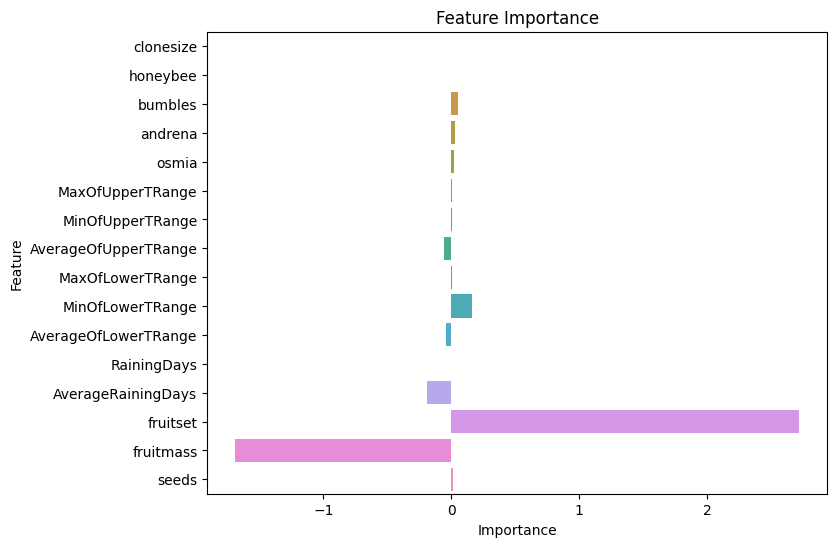

In [23]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LOGARITMO(X, y)

lista_transformacao_utilizado.append('LOGARITMO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 403.5776725653251
Desvio padrão dos scores de MAE: 4.794395342228028


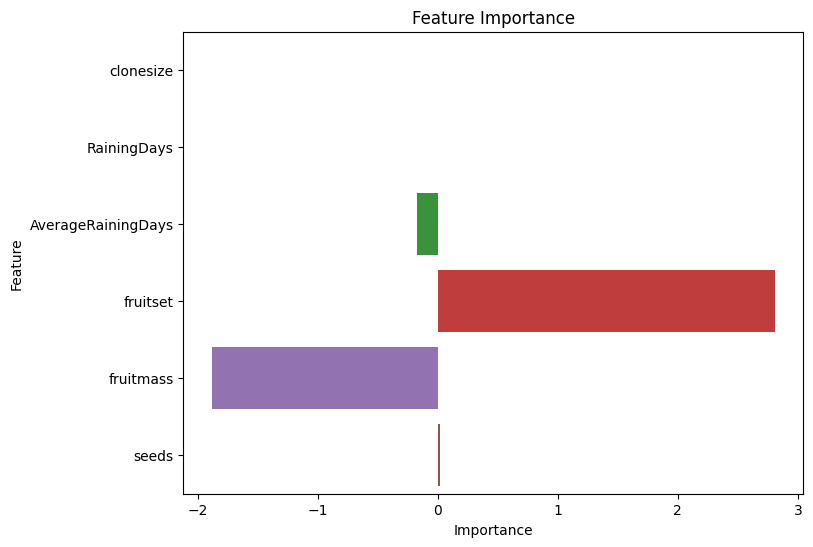

In [24]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_LOGARITMO(X, y)

lista_transformacao_utilizado.append('LOGARITMO')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## RAIZ QUADRADA

In [25]:
def teste_de_modelo_RAIZ(X, y, n_splits=5):

    # Transformação logaritmica
    y['yield'] = np.sqrt(y["yield"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        OLS = LinearRegression()
        OLS = OLS.fit(X_train, y_train)
        y_pred = OLS.predict(X_test).squeeze().tolist()

        # Convertendo listas para arrays NumPy
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)


        y_pred_corrigido = y_pred ** 2
        y_test_corrigido = y_test ** 2

        MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)
        MAE_scores.append(MAE)


    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = OLS.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 384.0064362961031
Desvio padrão dos scores de MAE: 16.334894368388145


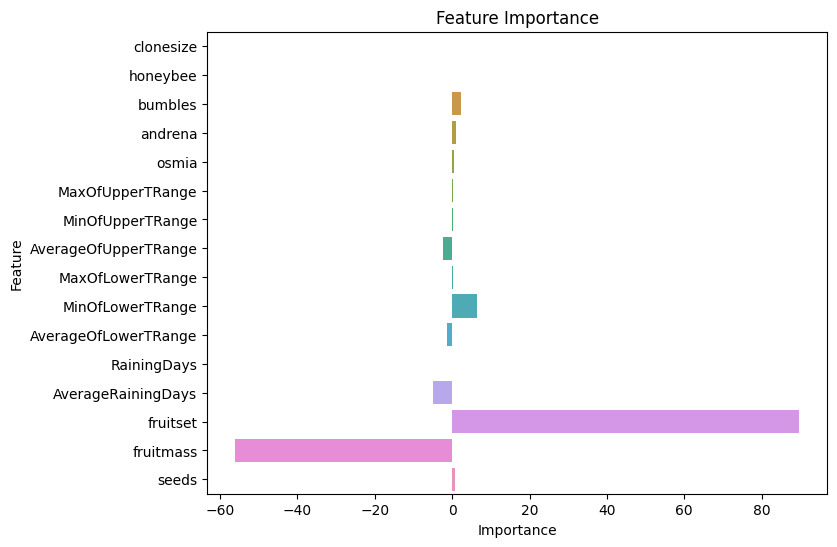

In [26]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RAIZ(X, y)

lista_transformacao_utilizado.append('RAIZ QUADRADA')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 379.4860387199985
Desvio padrão dos scores de MAE: 5.142626291634462


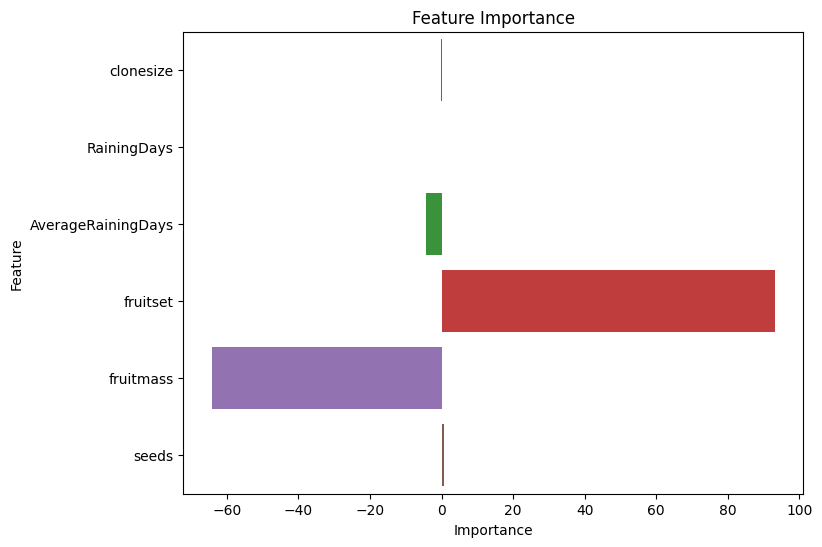

In [27]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RAIZ(X, y)

lista_transformacao_utilizado.append('RAIZ QUADRADA')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## TRANSFORMAÇÃO RECÍPROCA

In [28]:
def teste_de_modelo_RECIPROCA(X, y, n_splits=5):

    # Transformação logaritmica
    y['yield'] = 1/y["yield"]

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        OLS = LinearRegression()
        OLS = OLS.fit(X_train, y_train)
        y_pred = OLS.predict(X_test).squeeze().tolist()

        # Convertendo listas para arrays NumPy
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)


        y_pred_corrigido = 1/y_pred 
        y_test_corrigido = 1/y_test 

        MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)
        MAE_scores.append(MAE)


    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = OLS.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 522.79225368742
Desvio padrão dos scores de MAE: 7.448004161941365


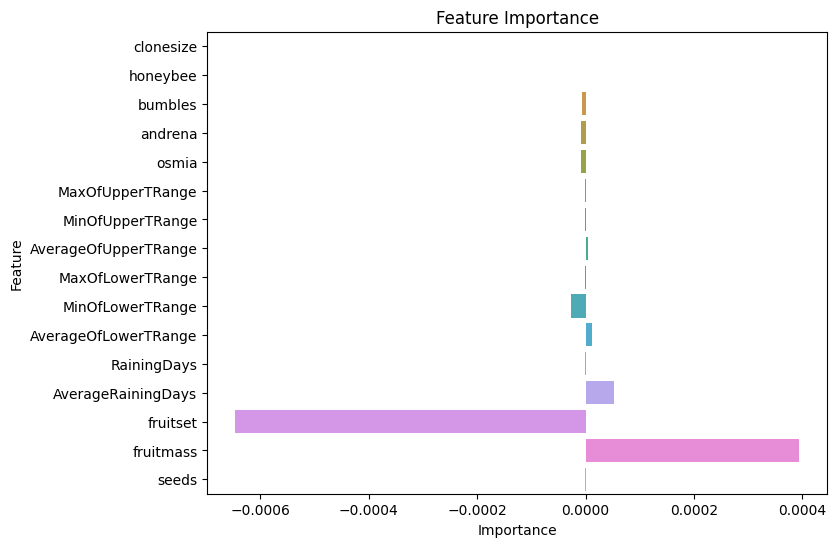

In [29]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RECIPROCA(X, y)

lista_transformacao_utilizado.append('RECÍPROCA')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 523.1332562735889
Desvio padrão dos scores de MAE: 5.466547145340667


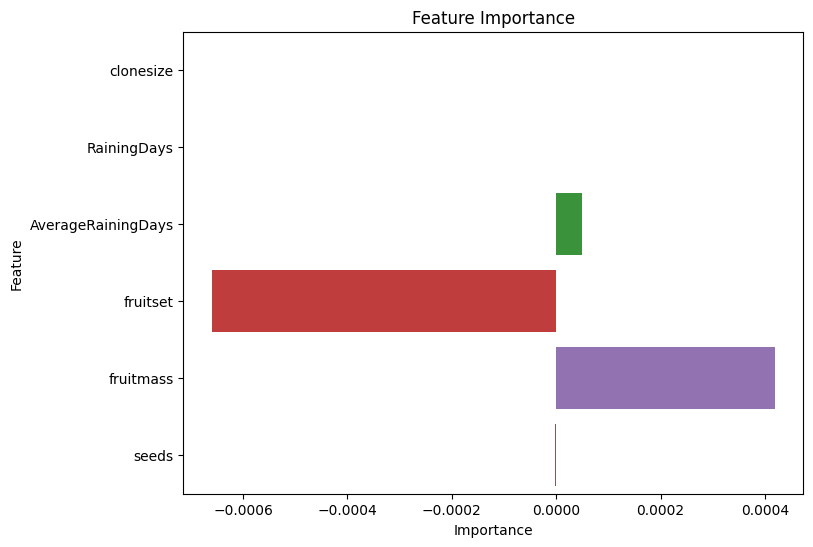

In [30]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_RECIPROCA(X, y)

lista_transformacao_utilizado.append('RECÍPROCA')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## BOX COX

In [31]:
def teste_de_modelo_BOXCOX(X, y, n_splits=5):

    # Transformação de Box Cox
    boxcox_transformer = PowerTransformer(method='box-cox')


    # Reshape y para uma matriz bidimensional
    y_reshaped = np.array(y['yield']).reshape(-1, 1)
    
    y_boxcox = boxcox_transformer.fit_transform(y_reshaped)
    
    y['yield'] = y_boxcox.flatten()

    # y['yield']  = boxcox_transformer.fit_transform(y["yield"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        OLS = LinearRegression()
        OLS = OLS.fit(X_train, y_train)
        y_pred = OLS.predict(X_test).squeeze().tolist()



        # Convertendo listas para arrays NumPy
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)

        # Remodelar para uma matriz bidimensional
        y_pred = y_pred.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        
        y_pred_corrigido = boxcox_transformer.inverse_transform(y_pred)
        y_test_corrigido = boxcox_transformer.inverse_transform(y_test)
    

        
        # Verificar se há valores NaN nos dados
        if np.isnan(y_pred_corrigido).any() or np.isnan(y_test_corrigido).any():
            print("Os dados contêm valores NaN. Ignorando esta divisão.")
            continue

        MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)
        MAE_scores.append(MAE)


    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = OLS.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Os dados contêm valores NaN. Ignorando esta divisão.
Média dos scores de MAE: 375.90478124787234
Desvio padrão dos scores de MAE: 3.7944827629452194


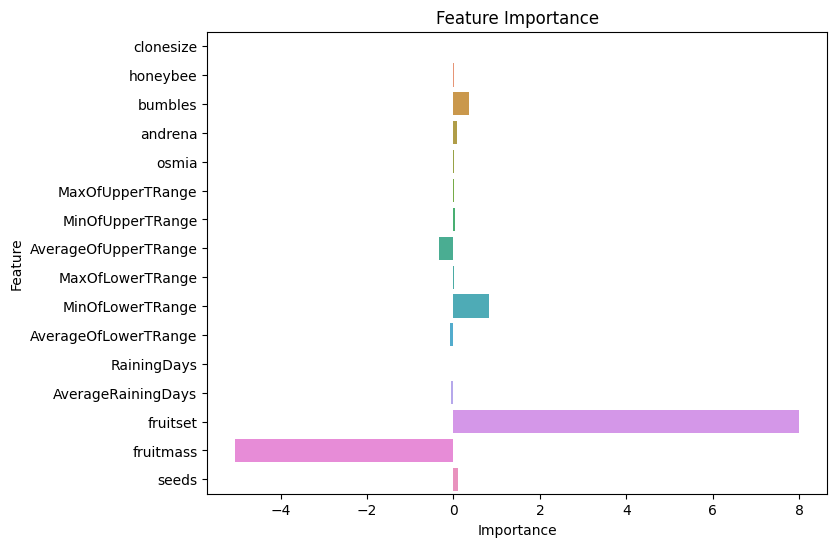

In [32]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_BOXCOX(X, y)

lista_transformacao_utilizado.append('BOXCOX')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 379.2537963888677
Desvio padrão dos scores de MAE: 5.886854252048312


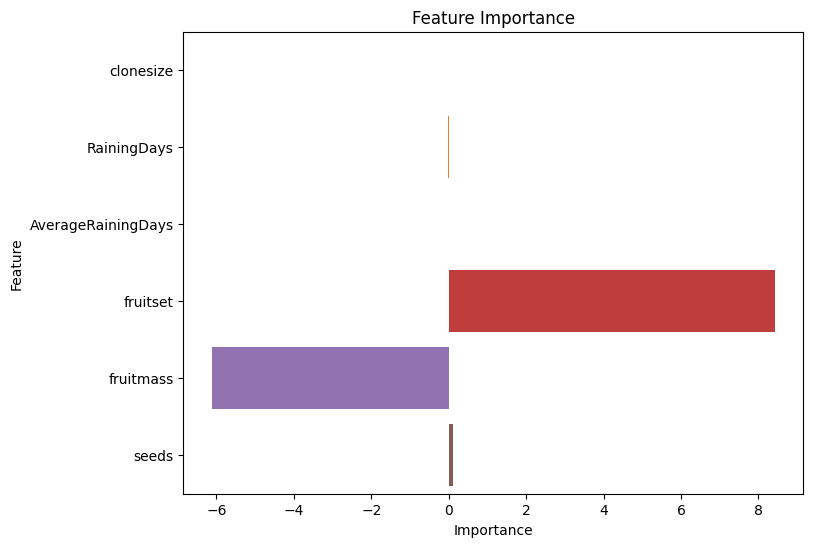

In [33]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_BOXCOX(X, y)

lista_transformacao_utilizado.append('BOXCOX')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

## YEO-JOHNSON

In [34]:
def teste_de_modelo_YEOJOHNSON(X, y, n_splits=5):

    # Transformação de Box Cox
    boxcox_transformer = PowerTransformer(method='yeo-johnson')


    # Reshape y para uma matriz bidimensional
    y_reshaped = np.array(y['yield']).reshape(-1, 1)
    
    y_boxcox = boxcox_transformer.fit_transform(y_reshaped)
    
    y['yield'] = y_boxcox.flatten()

    # y['yield']  = boxcox_transformer.fit_transform(y["yield"])

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=10)
    MAE_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        OLS = LinearRegression()
        OLS = OLS.fit(X_train, y_train)
        y_pred = OLS.predict(X_test).squeeze().tolist()



        # Convertendo listas para arrays NumPy
        y_pred = np.array(y_pred)
        y_test = np.array(y_test)

        # Remodelar para uma matriz bidimensional
        y_pred = y_pred.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)

        
        y_pred_corrigido = boxcox_transformer.inverse_transform(y_pred)
        y_test_corrigido = boxcox_transformer.inverse_transform(y_test)
    

        
        # Verificar se há valores NaN nos dados
        if np.isnan(y_pred_corrigido).any() or np.isnan(y_test_corrigido).any():
            print("Os dados contêm valores NaN. Ignorando esta divisão.")
            continue

        MAE = mean_absolute_error(y_true=y_test_corrigido, y_pred=y_pred_corrigido)
        MAE_scores.append(MAE)


    # Exibir a média e o desvio padrão dos scores de MAE
    print(f'Média dos scores de MAE: {np.mean(MAE_scores)}')
    print(f'Desvio padrão dos scores de MAE: {np.std(MAE_scores)}')

    # Coeficientes do modelo (feature importance) e nomes das features
    feature_importance = OLS.coef_[0]
    feature_names = X.columns  # Substitua pelos nomes reais das suas features

    # Criar um DataFrame para facilitar a plotagem
    df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

    # Plotar a importância dos recursos
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=df_importance, orient='h')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.show()

    return np.mean(MAE_scores), len(feature_names)

### TODAS AS FEATURES

Média dos scores de MAE: 688587.1550539562
Desvio padrão dos scores de MAE: 1376422.5001997342


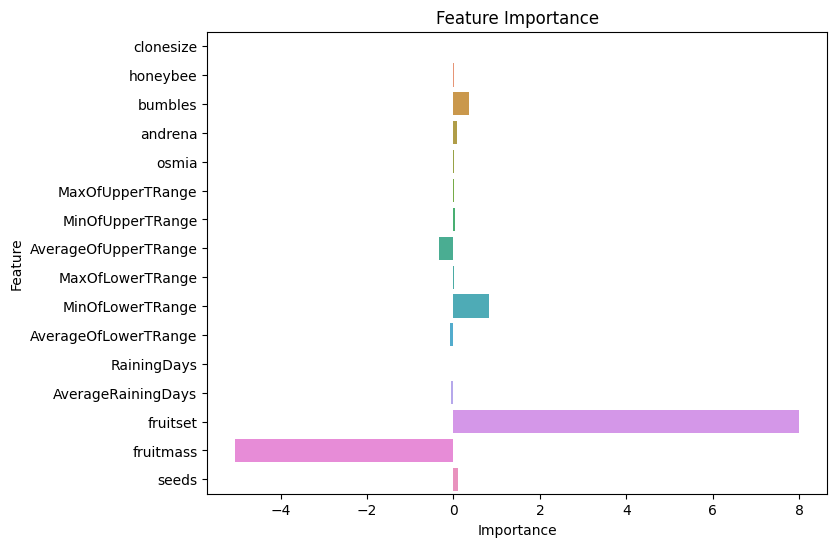

In [35]:
X = df_train.drop(columns=['id', 'yield'], axis=1)
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_YEOJOHNSON(X, y)

lista_transformacao_utilizado.append('YEO-JOHNSON')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

### SOMENTE FEATURES CORRELACIONADAS COM VARIÁVEL TARGET

Média dos scores de MAE: 379.2539283643917
Desvio padrão dos scores de MAE: 5.8867934683344485


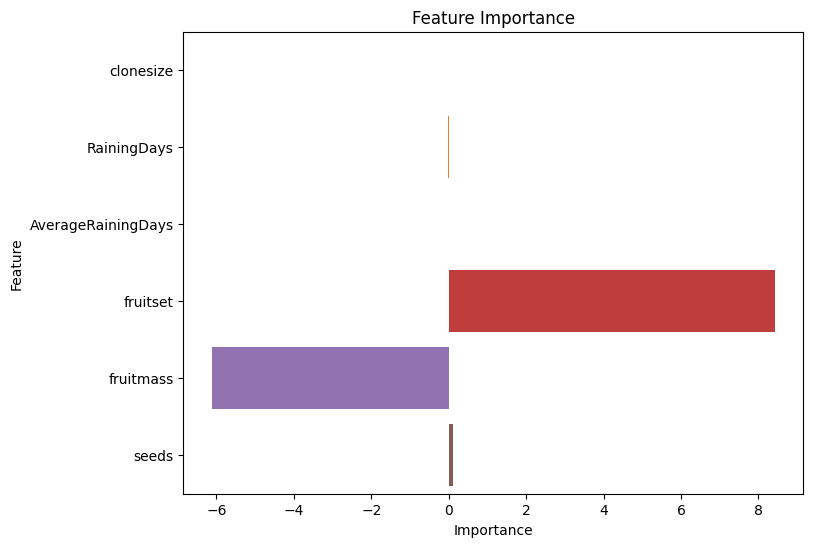

In [36]:
X = df_train[['clonesize', 'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds']]
y = df_train[['yield']]

MAE_modelo, num_features  = teste_de_modelo_YEOJOHNSON(X, y)

lista_transformacao_utilizado.append('YEO-JOHNSON')
lista_num_features.append(num_features)
lista_MAE.append(MAE_modelo)

# Resultados

In [37]:
resultados_modelos = pd.DataFrame({'TRANSFORMAÇÃO':lista_transformacao_utilizado,
             'NUM_FEATURES':lista_num_features,
             'MAE':lista_MAE})

resultados_modelos.sort_values(by='MAE')

,TRANSFORMAÇÃO,NUM_FEATURES,MAE
1,SEM TRANSFORMAÇÃO,6,372.570830
8,BOXCOX,16,375.904781
0,SEM TRANSFORMAÇÃO,16,376.173783
9,BOXCOX,6,379.253796
11,YEO-JOHNSON,6,379.253928
5,RAIZ QUADRADA,6,379.486039
4,RAIZ QUADRADA,16,384.006436
3,LOGARITMO,6,403.577673
2,LOGARITMO,16,430.561578
6,RECÍPROCA,16,522.792254


A partir da comparação das transformações , vamos seguir com duas transformações para os próximos passos: SEM TRANSFORMAÇÃO E BOX-COX